# Overview

This notebook records my model and results visualization.

The content includes:

1. Pre-training pipeline (encoding, transform, over/under-sampling)

2. Define evaluation metrics (balanced accuracy and adjusted F1 score - main focus) 

3. Modeling training (logistic regression, XGBoost, random forest)

4. Grid search on the best-performed model

5. Future improvement

Thank you for taking the time to go through my work.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (balanced_accuracy_score, fbeta_score, ConfusionMatrixDisplay, classification_report,
                             matthews_corrcoef, PrecisionRecallDisplay, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
file = pd.read_pickle('data.pkl')

# Pre-training Pipeline

## Encoding and Normalization

In [3]:
## 25 features are selected to build the model.

continuous = ['availableMoney', 'currentBalance', 'transactionAmount', 'dailySpend', 
              'daysSinceOpen', 'daysExpired', 'daysSinceAddressChange', 'pastFraudInAccount', 
              'pastVisitsToMerchant', 'pastFraudInMerchant']

categorical = ['acqCountry', 'merchantCountryCode', 'creditLimit', 'timeOfDay',
               'posEntryMode', 'posConditionCode', 'merchantCategoryCode',
               'transactionType', 'cardPresent', 'expirationDateKeyInMatch', 
               'CVVMatch', 'multiSwipe', 'frequentTransactions', 'missingCardNumber']

X = continuous + categorical
y = 'isFraud'

# Drop unused columns

file = file[X+[y]]

In [4]:
# Construct preprocessing pipeline

cats = [
    'creditLimit',
    'merchantCountryCode',
    'posEntryMode',
    'posConditionCode',
    'merchantCategoryCode',
    'transactionType'
]
boolean = [
    'cardPresent', 
    'expirationDateKeyInMatch',
    'CVVMatch', 
    'multiSwipe', 
    'frequentTransactions', 
    'missingCardNumber'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('normalizer', PowerTransformer(), continuous),
        ('cat', OrdinalEncoder(), cats)
    ],
    remainder = 'passthrough')

In [5]:
# Data type conversion
file[boolean] = file[boolean].astype(int)
file[cats] = file[cats].astype(str)
file[y] = file[y].astype(int)

# Preprocessor pipeline

X_transformed = preprocessor.fit_transform(file[X])

# Split data
random_seed = 4321
X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(X_transformed, file[y], test_size=0.1, random_state=random_seed)

In [6]:
print('Number of rows in training dataset:', len(X_train_imbalanced), 
      '\nNumber of rows in testing dataset:', len(X_test))

Number of rows in training dataset: 707098 
Number of rows in testing dataset: 78567


## Undersampling and Oversampling

In [7]:
values, counts = np.unique(y_train_imbalanced,return_counts=True)
print('Imbalanced ratio: ',round(counts[1]/counts[0],2))

Imbalanced ratio:  0.02


~ **1:50 distribution** for minority and majority class.
<br>I choose to **downsampling** majority class to 20%, and **upsampling** minority class to make a balance dataset.

In [8]:
# Perform undersample and oversample

under = RandomUnderSampler(sampling_strategy=0.1, random_state=random_seed)
over = SMOTE(sampling_strategy=1, random_state=random_seed)

X_train,y_train = under.fit_resample(X_train_imbalanced,y_train_imbalanced)
X_train,y_train = over.fit_resample(X_train,y_train)
values, counts = np.unique(y_train,return_counts=True)

print('Imbalanced ratio: ',round(counts[1]/counts[0],2), 'Shape of target variable: ', values, counts)

Imbalanced ratio:  1.0 Shape of target variable:  [0 1] [112080 112080]


In [9]:
# Run evaluation metrics and graphics

plt.rcParams["figure.figsize"] = (8,8)
plt.rc('font', size=12)

def evaluate(y_true, y_pred):
    
    print('Balanced accuracy:',balanced_accuracy_score(y_true, y_pred))
    print('Adjusted F1 score:',fbeta_score(y_true, y_pred, beta=5))
    print('MCC:', matthews_corrcoef(y_true, y_pred))
    print('Report: \n', classification_report(y_true, y_pred))
    
    display = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, cmap=plt.cm.Blues
    )
    _ = display.ax_.set_title("Confusion Matrix")
    
    return None

def plot_feature_importance(estimator):
    
    ordered = pd.DataFrame({'feature':X, 'feature importance':estimator.feature_importances_}).sort_values('feature importance', ascending=False)
    fig, ax = plt.subplots(figsize=(5,10))
    sns.barplot(y='feature', x='feature importance', data=ordered, orient='h')
    ax.set_title('Feature Importance')
    plt.show()
    
    return None

In [10]:
# Select the threshold on orginal imbalanced dataset

def classify(threshold, y_prob):
    return [1 if y_j[0] < threshold else 0 for y_j in y_prob]

def select_threshold(y_prob, y_true):
    
    score, tuned_threshold, prediction = 0, 0, []
    for i in range(0, 101, 5):
        threshold = i/100
        y_threshold_i = classify(threshold, y_prob)
        f = balanced_accuracy_score(y_true, y_threshold_i)
        if f > score: 
            score, tuned_threshold, prediction = f, threshold, y_threshold_i
    print('Best threshold:', tuned_threshold)

    return tuned_threshold

def calculate_threshold(estimator, X_train, y_train):
    
    y_train_prob = estimator.predict_proba(X_train)
    threshold = select_threshold(y_train_prob, y_train)
    
    return threshold

def review(estimator, X_train, y_train, X, y):
    
    threshold = calculate_threshold(estimator, X_train, y_train)
    y_prob = estimator.predict_proba(X)
    y_pred = classify(threshold, y_prob)
    evaluate(y, y_pred)

    return None

# Evaluation Metrics

**Main focus**
<br>Balanced accuracy and adjusted(beta) F1 score 

**Reasoning** 
<br>I spent some time deciding which metrics to use for this model evaluation. Obviously, we want to **detect more fraud cases**(true positives). 

But a **high false-positive rate** will cause a lot of users' **not using our card regularly**, a **high false-negative rate** will cause **huge loss** for the bank and customers. However, these two scenarios have **different opportunity costs**. 

At first, I try to use **F1 score** as my major metric, then I found that will **lose a lot of true positive(fraudulent) cases** to false negative as it **consider too much about false-positive rates**. So I think the best metric should take into consideration this issue, such as a **beta F1 score**. As the weight(beta) should be derived from real revenue-cost analysis, here I assume a hypothetical value that seems right to me. I also look at **balanced accuracy** and **Matthew's correlation coefficient**. 

**Testing process**
<br>Models are tested on the original **imbalanced dataset** as I didn't resample the testing dataset, and I think it can give me a better idea of how it will perform in practice.
All the parameters used here went through **first-round tuning**, to maintain my report clean, it is hard to re-show all the tuning processes here. I will try to explain all the parameters' effects and select the best one to do the grid search here.

## Logistic Regression (with L1 regularization)

In [11]:
# Add l1 penalty term since there's multicollinearity in features.

lr = LogisticRegression(max_iter = 1000, penalty='l1', random_state=random_seed, C=0.1, # inverse of regularization strength, I used small C to give high penalty for multicollinearity
                        solver = 'liblinear').fit(X_train, y_train)

Best threshold: 0.55
Balanced accuracy: 0.7546415167109851
Adjusted F1 score: 0.4636888703807644
MCC: 0.13331959643117602
Report: 
               precision    recall  f1-score   support

           0       1.00      0.69      0.81     77372
           1       0.04      0.82      0.07      1195

    accuracy                           0.69     78567
   macro avg       0.52      0.75      0.44     78567
weighted avg       0.98      0.69      0.80     78567



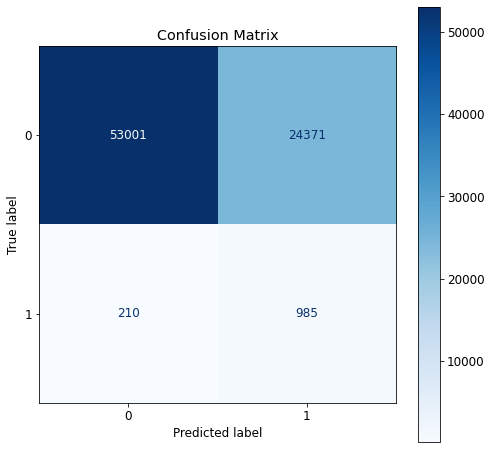

In [12]:
review(lr, X_train_imbalanced, y_train_imbalanced, X_test, y_test)

### Model Highlight

1. For logistic regression, I think the model is okay because has successfully identified fraud cases with a **recall rate of 0.82**.

2. But the **precision of True label** is pretty low, which means that the model is cautious, it will raised flags when there is a potential fraud, and it will also **affect users' regular financial activities**. 

3. The metrics are very close in training and testing dataset, so the model is not over or under fitting. MCC score also suggests that I should try other methods. 

## Random Forest Classifier

In [13]:
# At first round of tuning, other parameters doesn't affect the performance a lot

rf = RandomForestClassifier(max_samples=0.2,  # percentage of samples used in each tree, a lower value try to keep it from overfitting 
                            n_jobs=-1, random_state=random_seed).fit(X_train, y_train)

Best threshold: 0.6
Balanced accuracy: 0.7734278745059731
Adjusted F1 score: 0.5134739519593021
MCC: 0.18735143096251825
Report: 
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     77372
           1       0.07      0.69      0.13      1195

    accuracy                           0.86     78567
   macro avg       0.53      0.77      0.52     78567
weighted avg       0.98      0.86      0.91     78567



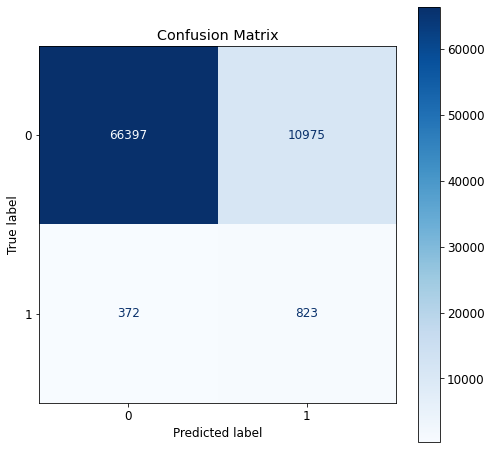

In [14]:
review(rf, X_train_imbalanced, y_train_imbalanced, X_test, y_test)

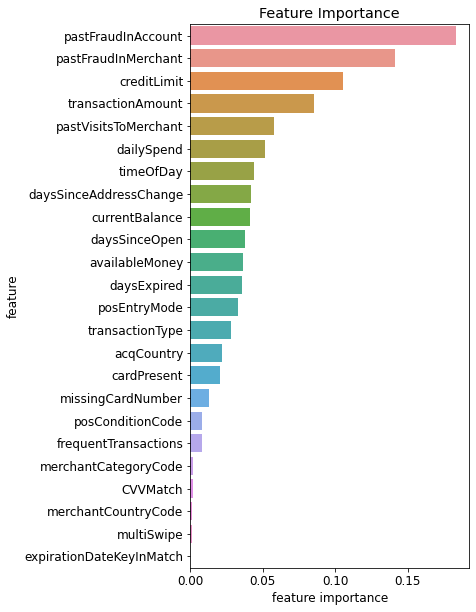

In [15]:
plot_feature_importance(rf)

### Model hightlight

1. Random forest is **better** than logistic regression in all the above metrics. 

2. It throws **~55% fewer false alarms** than logistic regression. But the **true positive rate is also lower**.

3. Feature importance plot shows it **'ignored' some variables**, and focus more on features related to **past activities**.

## Gradient Boosting Classifier (XGBoost)

In [16]:
params = {'max_depth': 10,  # depth of tree
          'eta': 0.1,       # learning rate
          'alpha': 0.1,     # L1 regularization term on weights
          'subsample':0.9,   # fight for overfitting
          'use_label_encoder': False, 
          'random_state': random_seed, 
          'objective': 'binary:logistic', 
          'eval_metric': 'logloss', 
          'n_jobs':-1
         }

xgboost = xgb.XGBClassifier(**params)
xgboost.fit(X_train, y_train)

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, eval_metric='logloss', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=4321, reg_alpha=0.100000001,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', use_label_encoder=False, ...)

Best threshold: 0.8
Balanced accuracy: 0.8155562962999816
Adjusted F1 score: 0.5556624137120386
MCC: 0.1879160214604137
Report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.88     77372
           1       0.06      0.84      0.11      1195

    accuracy                           0.79     78567
   macro avg       0.53      0.82      0.50     78567
weighted avg       0.98      0.79      0.87     78567



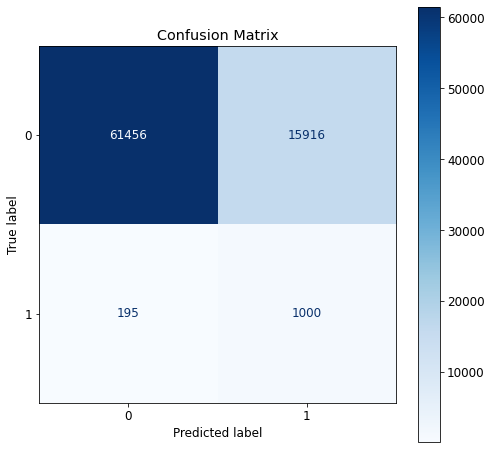

In [17]:
review(xgboost, X_train_imbalanced, y_train_imbalanced, X_test, y_test)

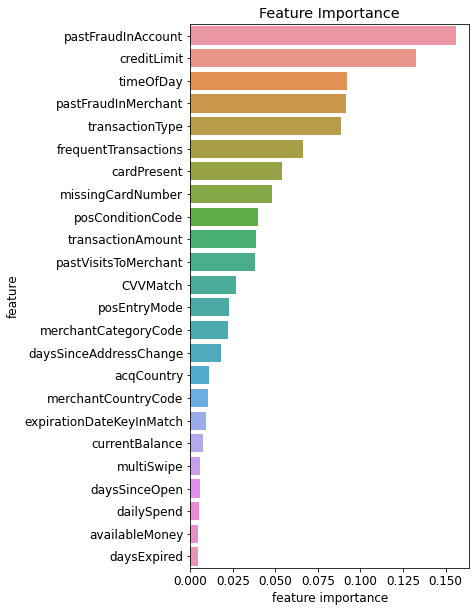

In [18]:
plot_feature_importance(xgboost)

### Model Highlight

1. For XGBoost model has the **highest score** for all evaluation metrics.

2. The **false positive rate is reduced by 40%** than linear regression. And it also can **detect more fraud cases**(true positive) than previous models.

### Model Comparison

I think **XGBoost** is the winner here. It has the **highest balanced accuracy and adjusted F1 score**. Feature importance plot shows it **takes a lot of features into consideration**, which is a good thing because I think for a **good** model to capture the fraudulent events, it should not only focus on **historical records** but also **short-term features** to detect new fraud.

**Random Forest** also works pretty well but with the **sacrifice** of detection ability. 

**Logistic regression** does not work as well as the others, it may **oversimplify** the correlation between the features and our target.

So I choose XGBoost to do the final model tuning.


## Grid Search on XGBoost

In [20]:
xgb_model = xgb.XGBClassifier()

param_grid = {'objective': ['binary:logistic'],
              'eval_metric': ['logloss'],
              'learning_rate': [0.05, 0.1],  # `eta` value
              'alpha': [0.1],  # l1 regularization
              'max_depth': [10], 
              'subsample': [0.8, 0.9], # try to fight for overfitting 
              'colsample_bytree': [0.9], 
              'n_estimators': [150, 200], 
              'use_label_encoder': [False],
              'n_jobs': [-1]
             }

gs_xgb = GridSearchCV(estimator=xgb_model, scoring='balanced_accuracy', cv=5, n_jobs=-1,
                      param_grid = param_grid).fit(X_train, y_train)

# The warning is an XGBoost built-in deprecated warning, I checked their GitHub page and the new version hasn't been released from xgboost yet.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWar

In [21]:
print(gs_xgb.best_params_, '\n', 'Best training score:', gs_xgb.best_score_)

{'alpha': 0.1, 'colsample_bytree': 0.9, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'objective': 'binary:logistic', 'subsample': 0.8, 'use_label_encoder': False} 
 Best training score: 0.9392933618843683


Best threshold: 0.8
Balanced accuracy: 0.8051025237633672
Adjusted F1 score: 0.5583295721785401
MCC: 0.20605180394814246
Report: 
               precision    recall  f1-score   support

           0       1.00      0.85      0.92     77372
           1       0.07      0.76      0.13      1195

    accuracy                           0.85     78567
   macro avg       0.53      0.81      0.53     78567
weighted avg       0.98      0.85      0.91     78567



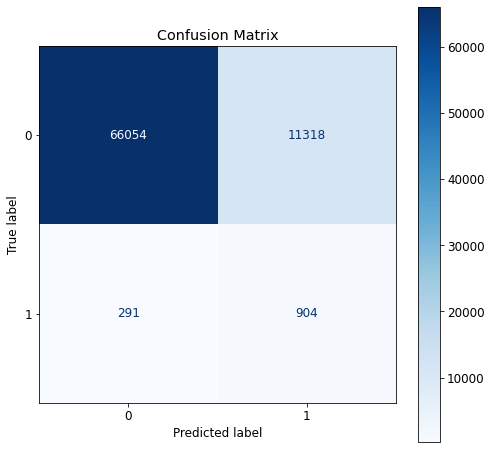

In [22]:
review(gs_xgb.best_estimator_, X_train_imbalanced, y_train_imbalanced, X_test, y_test)

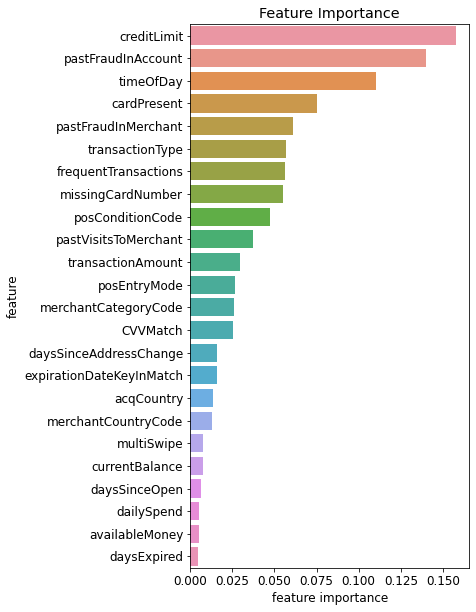

In [23]:
plot_feature_importance(gs_xgb.best_estimator_)

After tuning the model, the **false postive cases** decrease by 25%, true negative cases also increase by 10%, and it still outperform the random forest on true positive detection. But the **true positive cases** decrease by 10% than previous base model. This is a trade-off that need further discussion. Overall I think the model works pretty well.

In [24]:
joblib.dump(gs_xgb.best_estimator_, 'CapitalOne_DSC_XGBoost.pkl', compress=1)

['CapitalOne_DSC_XGBoost.pkl']

## Future improvements:

1. This dataset contains **one year of data**, for some of the features I created include **previous information** of the customer or merchant, but they won't provide much information **at the beginning of the year**. I think that's one limit of my model. It **shouldn't be a problem in practice** since we will have continuous time series data. 

2. An **alternative way** to do the train and test is (1-10)|(11-12). Train on the first ten months' of data and test on the last two months'. Using this split method, intuitively I think the model may **rely more on past fraud records** and I would need to give more weight to how to identify new fraud activities. 

3. Split the project into two models, **early detection and frequent fraud identification**.

3. If **data volume** is larger, the modeling process can also be written in **SparkML or H2O**, which could potentially speed up the training process. 

4. Current **grid search** didn't improve much performance and Random forest and XGBoost classifier are both overfitting. I will work on fine-tuning the model if got extra time.

5. As mentioned in the previous section, for **evaluation metrics**, we might want to consider the real cost of letting one fraud walk free and make one 'innocent' transaction stop. And then derive an adjusted F1 score as a metric to train the model.
